# MaterialsCoord benchmarking – over-binding v. under-binding

Plot whether different bonding algorithms tend to over-bind or under-bind.

*Written using:*
- MaterialsCoord==0.1.0

*Authors: Alex Ganose (10/12/19)*

---

First, lets initialize the near neighbor methods we are interested in.

In [1]:
from pymatgen.analysis.local_env import BrunnerNN_reciprocal, EconNN, JmolNN, \
                                        MinimumDistanceNN, MinimumOKeeffeNN, MinimumVIRENN, \
                                        VoronoiNN, CrystalNN

nn_methods = [
    MinimumDistanceNN(),  MinimumOKeeffeNN(), MinimumVIRENN(), JmolNN(), 
    EconNN(), BrunnerNN_reciprocal(), VoronoiNN(tol=0.5), CrystalNN()
]

Next, import the benchmark and choose which structures we are interested in.

In [2]:
from materialscoord.core import Benchmark

structure_groups = ["common_binaries", "elemental", "A2BX4", "ABX3", "ABX4"]

bm = Benchmark.from_structure_group(structure_groups)

Calculate the raw site scores (a list of $\mathrm{CN}^\mathrm{calc} - \mathrm{CN}^\mathrm{expected}$ for each inequivalent site). Note that the raw site score can sometimes be zero even if the correct bonding is not not determined. This can arise when the coordination numbers themselves are correct but the bonds themselves aren't. For example, if the human interpreted bonding is {"Cl": 2, "Br": 3} and the predicted bonding is {"Cl": 3, "Br": 2}, the raw score for that site will be 0.

In [3]:
site_scores = bm.score(nn_methods, return_raw_site_scores=True)
site_scores.loc["Total"] = site_scores.sum(axis=0)

/Users/alex/dev/src/pymatgen/pymatgen/analysis/local_env.py:3951: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/Users/alex/dev/src/pymatgen/pymatgen/analysis/local_env.py:3745: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(


Create two DataFrames that will be used for plotting. One contains all the results, the other contains just the results that are not 0 (i.e., it contains only errors).

In [4]:
import pandas as pd
import numpy as np

score_data = {"algorithm": [], "score": []}
error_data = {"algorithm": [], "score": []}

for column in site_scores.columns:
    answers = np.array(site_scores[column].loc["Total"])
    errors = answers[answers != 0]

    score_data["algorithm"].extend([column] * len(answers))
    score_data["score"].extend(answers)
    
    error_data["algorithm"].extend([column] * len(errors))
    error_data["score"].extend(errors)

score_df = pd.DataFrame(score_data)
error_df = pd.DataFrame(error_data)

Plot the results as a boxplot.

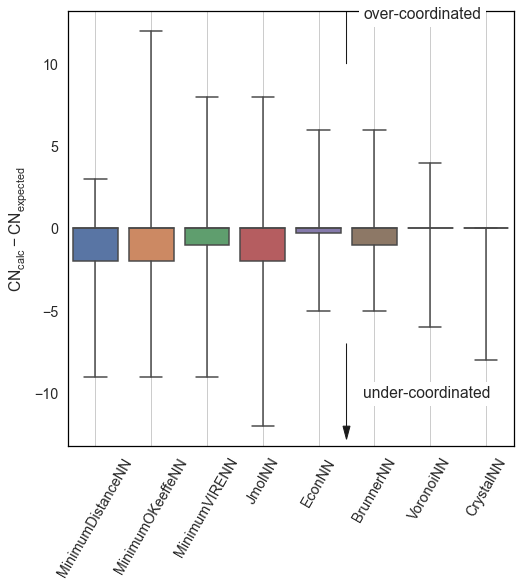

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font="Helvetica", font_scale=1.3, rc={"figure.figsize": (8, 8)})
sns.set_style("white", {"axes.edgecolor": "black", "axes.linewidth": 1.3})

plt.style.use({"mathtext.fontset": "custom", "mathtext.rm": "Arial", "axes.grid": True, "axes.grid.axis": "x"})
site_scores = site_scores.rename(columns={"BrunnerNN_reciprocal": "BrunnerNN"})

ax = sns.boxplot(x="algorithm", y="score", data=score_df, whis=[0, 100])
ax.set_xticks(list(range(len(site_scores.columns))))
ax.set_xticklabels(site_scores.columns, rotation=60)

ax.grid(axis='x')
ax.set(ylabel="$\mathrm{CN}_\mathrm{calc} - \mathrm{CN}_\mathrm{expected}$", xlabel="")

ax.arrow(4.5, -7, 0, -5, color='k', shape='full', fill=True, head_width=0.125, head_length=0.8)
ax.text(4.8, -10, "under-coordinated", verticalalignment="center", bbox={"facecolor": "white"})

ax.arrow(4.5, 10, 0, 5, color='k', shape='full', fill=True, head_width=0.125, head_length=0.8)
ax.text(4.8, 13, "over-coordinated", verticalalignment="center", bbox={"facecolor": "white"})

plt.show()

The empty boxes don't look that great. Let's try a violin plot instead.

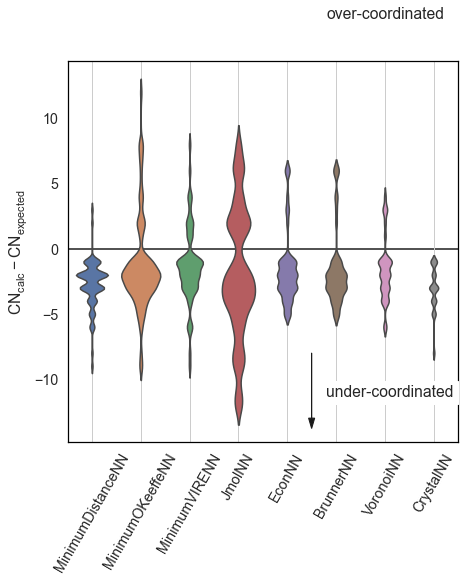

In [6]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(font="Helvetica", font_scale=1.3, rc={"figure.figsize": (7, 7)})
sns.set_style("white", {"axes.edgecolor": "black", "axes.linewidth": 1.3})

plt.style.use({"mathtext.fontset": "custom", "mathtext.rm": "Arial", "axes.grid": True, "axes.grid.axis": "x"})
site_scores = site_scores.rename(columns={"BrunnerNN_reciprocal": "BrunnerNN"})

ax = sns.violinplot(x="algorithm", y="score", data=error_df, scale="count", bw=0.15, inner=None)

ax.set_xticks(list(range(len(site_scores.columns))))
ax.set_xticklabels(site_scores.columns, rotation=60)
ax.axhline(y=0, c='k', zorder=-1, linewidth=1.5)
ax.grid(axis='x')
ax.set(ylabel="$\mathrm{CN}_\mathrm{calc} - \mathrm{CN}_\mathrm{expected}$", xlabel="")

ax.arrow(4.5, -8, 0, -5, color='k', shape='full', fill=True, head_width=0.125, head_length=0.8)
ax.text(4.8, -11, "under-coordinated", verticalalignment="center", bbox={"facecolor": "white"})

ax.arrow(4.5, 15, 0, 5, color='k', shape='full', fill=True, head_width=0.125, head_length=0.8)
ax.text(4.8, 18, "over-coordinated", verticalalignment="center", bbox={"facecolor": "white"})

plt.savefig(Path("plots", "over-under-binding.pdf"), bbox_inches="tight")
plt.show()

Much better!